### **This jupyter notebook contain the python code and all data processing and model training steps for diease recognition system from the human lung.**

### Author : Umidjon Sattorov machine learning engineer, successfull graduator of the courses in the platform skillbox and freecodecamp. Student of Mohirdev platform.

This task might be little challenging to solve because of the image data. For solving this problem, I am going to train convolutional neural networks from scratch and I try to use ready to apply algorithms like CNN from google company with the help of libraries like tensorflow and keras. Moreover I try to use libraries like fastai and so on if needed.

**Installing important libraries** 

In [1]:
#Installing important libraries(tensorflow with cpu only, but GPU version is more efficient and speedy compared to CPU version)
!pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ------------------------- -------------- 30.7/48.7 kB ? eta -:--:--
     ------------------------- -------------- 30.7/48.7 kB ? eta -:--:--
     -------------------------------------- 48.7/48.7 kB 492.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.0 MB 3.4 MB/s eta 0:01:53
   ---------------------------------------- 0.1/385.0 MB 3.4 MB/s eta 0:01:53
   ---------------------------------------- 0.1/385.0 MB 3.4 MB/s eta 0:01:53
   ---------------------------------------- 0.1/385.0 MB 491.5 kB/s eta 0:13:04
   ---------------------------------------- 0.1/385.0 MB 722.1 kB/s eta 0:08:54
   ---------------------------------------- 0.1/385.0 MB 722.1 kB/s eta 0:08:54
   ---------------------------------------- 0.1/385.0 MB 610.6 kB/s eta 0:10:31
   ---------------------------------------- 0.2/385.0 MB 692.4 kB/s eta 0:09:

**Data preprocessing**

In [1]:
#Loading necessary libraries first.
from tensorflow.data import Dataset
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, LeakyReLU, Dropout, Input, BatchNormalization
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#Visualization
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 

In [4]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(71.25491, shape=(), dtype=float32)


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
#Loading image data from the folder data and splitting image into training and test datasets
train_dir = './data/train/'
test_dir = './data/test/'

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = None
)

test_dataset = test_dataset.map(lambda x: x / 255.0)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 files.


In [3]:
#Creating fuction that converts the objects of image data generators into numpy arrays. 
def generator_to_array(generator) :
    images, labels = [], []
    for _ in range(len(generator)) : 
        batch_images, batch_labels = next(generator)
        images.append(batch_images)
        labels.append(batch_labels)
        
    return np.concatenate(images), np.concatenate(labels)

#Function for converting test dataset to numpy array
def test_to_array(dataset) :
    images = []
    for batch in dataset : 
        images.append(batch.numpy())
    return np.concatenate(images)

train_images, train_labels = generator_to_array(train_generator)
validation_images, validation_labels = generator_to_array(validation_generator)
test_images = test_to_array(test_dataset)

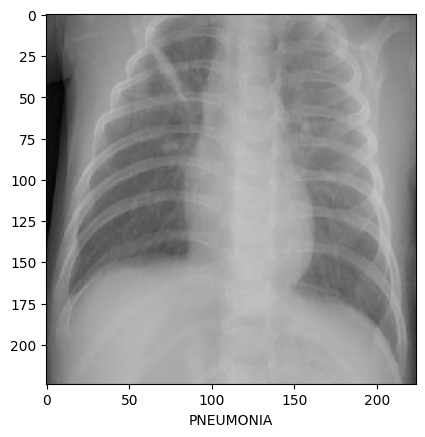

In [5]:
#Checking samples from the train and test dataset
generated_class_index = train_generator.class_indices
reversed_dict = {value: key for key, value in generated_class_index.items()}
IMG_INDEX = 6

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(reversed_dict[train_labels[IMG_INDEX]])
plt.show()

**Modelling**

Firstly I will start by creating custom convolutional networks using max pooling to reduce the size of the image and convolutional networks.(Partly detection by filters). If it doesn't work as we intended, I will use ready to use convolution layer from the company Google which is trained using 1.4 millions of image and can detect 1000 class of real world object. I will add my own forward-flow dense layers and configure them on my own. 

In [6]:
#Convolutional layers
custom_conv_umidjon = models.Sequential()
custom_conv_umidjon.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
custom_conv_umidjon.add(layers.MaxPooling2D((2, 2)))
custom_conv_umidjon.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
custom_conv_umidjon.add(layers.MaxPooling2D((2, 2)))
custom_conv_umidjon.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
custom_conv_umidjon.add(layers.MaxPooling2D((2, 2)))

#Dense layers
custom_conv_umidjon.add(layers.Flatten())
custom_conv_umidjon.add(layers.Dense(64, activation = 'relu'))
custom_conv_umidjon.add(layers.Dense(1, activation = 'sigmoid'))

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
custom_conv_umidjon.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Training the model and getting results
custom_conv_umidjon.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.AUC(name = 'roc_auc')])

history = custom_conv_umidjon.fit(train_images, train_labels, epochs = 8, 
                    validation_data = (validation_images, validation_labels))

Epoch 1/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 514ms/step - accuracy: 0.7866 - loss: 0.5085 - roc_auc: 0.7540 - val_accuracy: 0.9271 - val_loss: 0.1895 - val_roc_auc: 0.9721
Epoch 2/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 488ms/step - accuracy: 0.9548 - loss: 0.1154 - roc_auc: 0.9889 - val_accuracy: 0.9492 - val_loss: 0.1381 - val_roc_auc: 0.9854
Epoch 3/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 455ms/step - accuracy: 0.9647 - loss: 0.0904 - roc_auc: 0.9930 - val_accuracy: 0.9521 - val_loss: 0.1188 - val_roc_auc: 0.9876
Epoch 4/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 456ms/step - accuracy: 0.9773 - loss: 0.0670 - roc_auc: 0.9952 - val_accuracy: 0.9664 - val_loss: 0.1048 - val_roc_auc: 0.9912
Epoch 5/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 479ms/step - accuracy: 0.9787 - loss: 0.0562 - roc_auc: 0.9971 - val_accuracy: 0.9482 - val_loss: 0.1390 - val_roc_auc: 0.9851
Epoch 6/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.9894 - loss: 0.0346 - roc_auc: 0.9987 - val_accuracy: 0.9607 - val_loss: 0.1019 - 

Wow I have never expected the custom convolutional layer return such otustanding score withing only four epochs. It took almost 10 minutes to train, but the result from the model is great. Model doesn't seem like overtained because of the similarity between the metrics of the model in both training and test datasets. Let see if it is not biased to particular class.

131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step


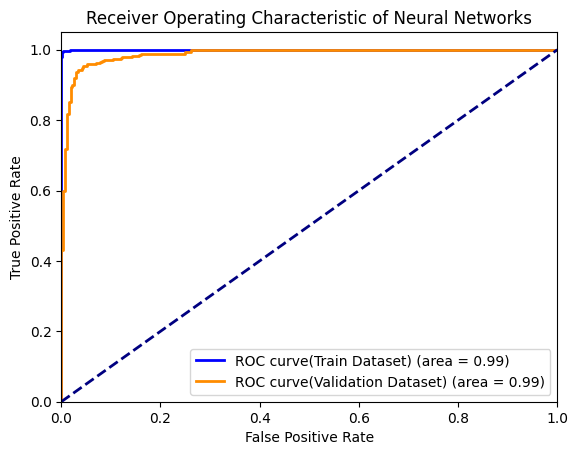

In [9]:
#Drawing receiver operating characteristics curve line in both train and test datasets
train_predictions = custom_conv_umidjon.predict(train_images).ravel()
valid_predictions = custom_conv_umidjon.predict(validation_images).ravel()

fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions)
fpr, tpr, thresholds = roc_curve(validation_labels, valid_predictions)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr_train, tpr_train, color = 'blue', lw = 2, label = 'ROC curve(Train Dataset) (area = %0.2f)' % roc_auc)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve(Validation Dataset) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Neural Networks')
plt.legend(loc = "lower right")
plt.show()

Ok, this model worked perfectly and performed well in our training and validation dataset. Model is not overtrained and hopefully, achieve great scores in test dataset. But before we move on, I think I have to set threshold value to prediction of my model and see roc_auc score with actual prediction.

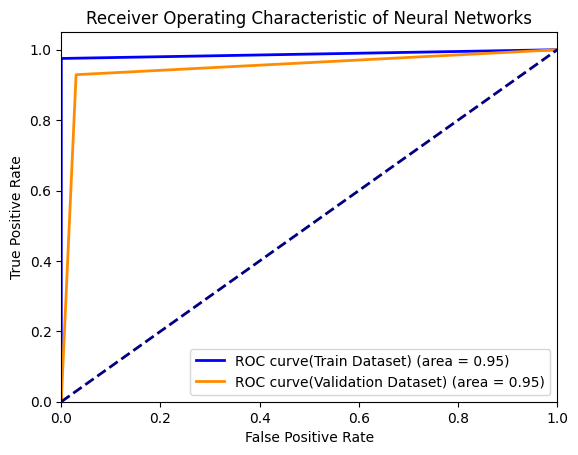

In [10]:
#Actual predictions
threshold = 0.94

train_predictions_real = (train_predictions > threshold).astype(int)
valid_predictions_real = (valid_predictions > threshold).astype(int)


fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions_real)
fpr, tpr, thresholds = roc_curve(validation_labels, valid_predictions_real)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr_train, tpr_train, color = 'blue', lw = 2, label = 'ROC curve(Train Dataset) (area = %0.2f)' % roc_auc)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve(Validation Dataset) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Neural Networks')
plt.legend(loc = "lower right")
plt.show()

Wow I have never expected that I had to set the threshold value of the dataset to 0.9. But this increased the metric score by 0.02 score. 

I think, I can show the sample prediction from the test dataset in this jupyter notebook.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


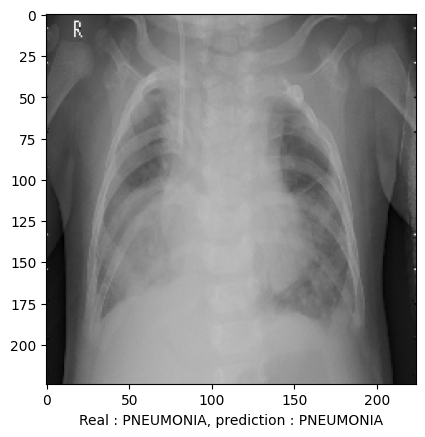

In [11]:
#Sample prediction 
smpl_img_index = 5

sample_image_from_valid = np.expand_dims(validation_images[smpl_img_index], axis = 0)
valid_example_prediction = custom_conv_umidjon.predict(sample_image_from_valid).ravel()

binary_prediction = 1 if valid_example_prediction >= threshold else 0

plt.imshow(validation_images[smpl_img_index], cmap = plt.cm.binary)
plt.xlabel(f"Real : {reversed_dict[validation_labels[smpl_img_index]]}, prediction : {reversed_dict[binary_prediction]}")
plt.show()

I think, model is doing great to predict in terms of prediction of penumonia. I think we can show the pictures where our model made mistake in terms of prediction of the disorder called pneumonia.

In [159]:
#Sample predictions for erroneus results
error_index_pred = {}
for i in range(0, len(validation_images)) :
    smpl_img_index = i

    sample_image_from_valid = np.expand_dims(validation_images[smpl_img_index], axis = 0)
    valid_example_prediction = custom_conv_umidjon.predict(sample_image_from_valid).ravel()

    binary_prediction = 1 if valid_example_prediction >= threshold else 0

    if reversed_dict[validation_labels[smpl_img_index]] != reversed_dict[binary_prediction] :
        error_index_pred[smpl_img_index] = binary_prediction
print(len(error_index_pred))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

Only 38 images out of 1043 images are predicted incorrectly. That is actually good.  Here are some images from incorrect predictions

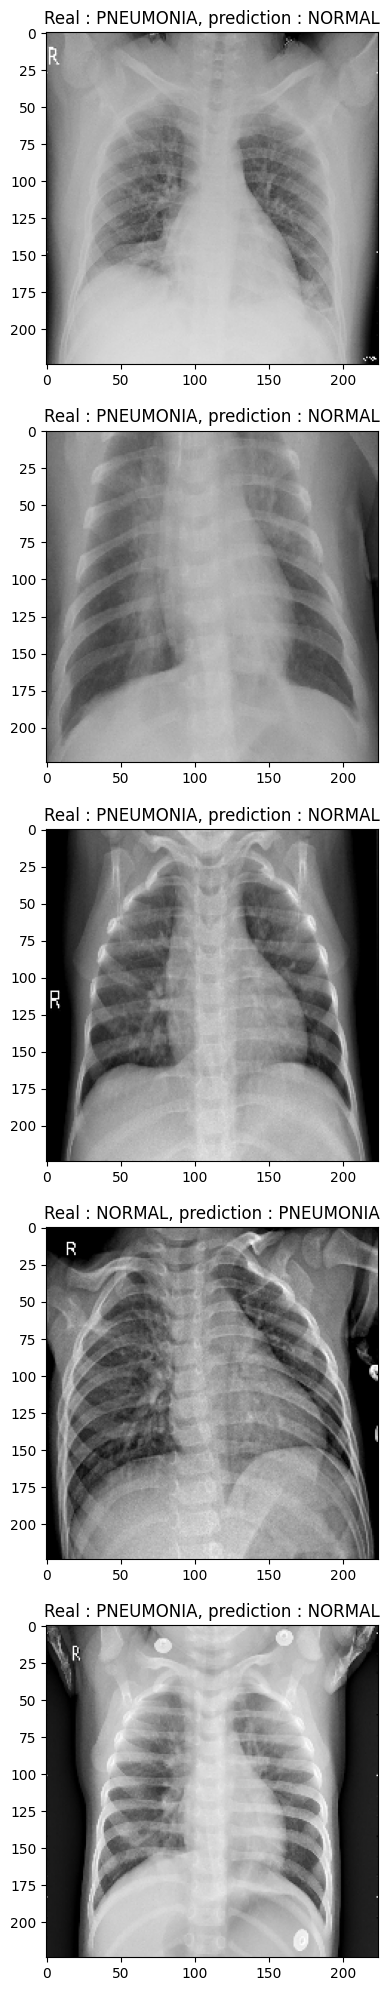

In [160]:
fig, axes = plt.subplots(5, 1, figsize=(5, 25))

keys_list = list(error_index_pred.keys())[:5]
values_list = list(error_index_pred.values())[:5]

for index_img, pred_index_img  in zip(range(0, 5), keys_list) :
    axes[index_img].imshow(validation_images[pred_index_img], cmap = plt.cm.binary)
    axes[index_img].set_title(f"Real : {reversed_dict[validation_labels[pred_index_img]]}, prediction : {reversed_dict[values_list[index_img]]}")

plt.show()

**Next model that I am going to use is pretraine model VGG19. It has more convolutional layers and already have trained with millions of data. I would configure this pretrained layers and incorporate with my own dense layers.**

In [18]:
#Creating new model with pretrained VGG19 model
base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False

x = base_model.output 
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.AUC(name = 'roc_auc')])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           12

 Total params: 23,235,905 (88.64 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [13]:
#Encoding labels before trainning on VGG19
train_labels_encoded = to_categorical(train_labels, num_classes = 2)
validation_labels_encoded = to_categorical(validation_labels, num_classes = 2)

In [19]:
#Training second model with pretrained VGG19
history_second_model = model.fit(train_images, train_labels, epochs = 10, 
                    validation_data = (validation_images, validation_labels))

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 619s 5s/step - accuracy: 0.8610 - loss: 0.4607 - roc_auc: 0.9064 - val_accuracy: 0.9703 - val_loss: 0.0827 - val_roc_auc: 0.9973
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.9750 - loss: 0.0649 - roc_auc: 0.9966 - val_accuracy: 0.9751 - val_loss: 0.0689 - val_roc_auc: 0.9986
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 682s 5s/step - accuracy: 0.9692 - loss: 0.0769 - roc_auc: 0.9947 - val_accuracy: 0.9741 - val_loss: 0.0730 - val_roc_auc: 0.9978
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 658s 5s/step - accuracy: 0.9880 - loss: 0.0285 - roc_auc: 0.9994 - val_accuracy: 0.9895 - val_loss: 0.0373 - val_roc_auc: 0.9990
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 683s 5s/step - accuracy: 0.9851 - loss: 0.0444 - roc_auc: 0.9973 - val_accuracy: 0.9751 - val_loss: 0.0623 - val_roc_auc: 0.9985
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 670s 5s/step - accuracy: 0.9637 - loss: 0.1218 - roc_auc: 0.9898 - val_accuracy: 0.9847 - val_loss: 0.0408 - val_ro

As I expected pretrained concolutional layers of neural network performed outstandingly and returned great metric scores.

131/131 ━━━━━━━━━━━━━━━━━━━━ 527s 4s/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step


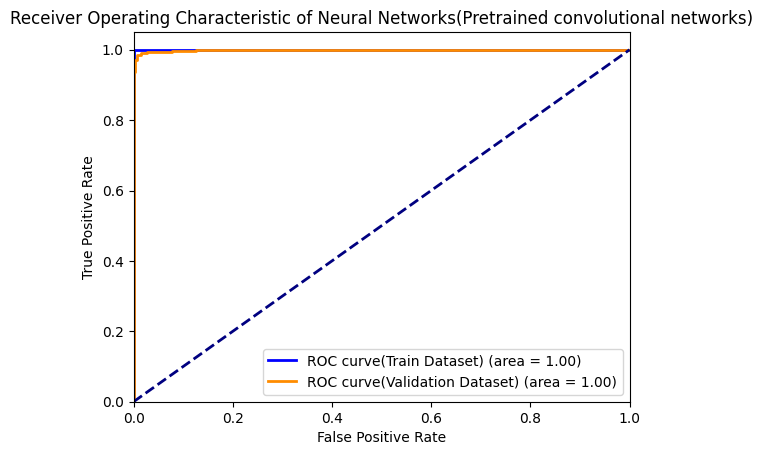

In [20]:
#Drawing receiver operating characteristics curve line in both train and test datasets
train_predictions = model.predict(train_images).ravel()
valid_predictions = model.predict(validation_images).ravel()

fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions)
fpr, tpr, thresholds = roc_curve(validation_labels, valid_predictions)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr_train, tpr_train, color = 'blue', lw = 2, label = 'ROC curve(Train Dataset) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve(Validation Dataset) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Neural Networks(Pretrained convolutional networks)')
plt.legend(loc = "lower right")
plt.show()

Ok we have to see the real roc-auc curve of the model after real predictions are extracted from the model.

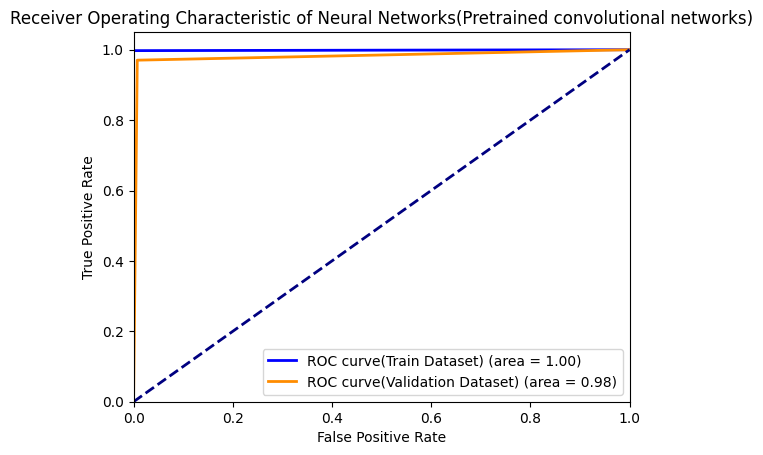

In [21]:
#Actual predictions
thres = 0.94

train_predictions_real = (train_predictions > thres).astype(int)
valid_predictions_real = (valid_predictions > thres).astype(int)


fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions_real)
fpr, tpr, thresholds = roc_curve(validation_labels, valid_predictions_real)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr_train, tpr_train, color = 'blue', lw = 2, label = 'ROC curve(Train Dataset) (area = %0.2f)' % roc_auc_train)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve(Validation Dataset) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Neural Networks(Pretrained convolutional networks)')
plt.legend(loc = "lower right")
plt.show()

Here we can see sample predictions from our model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


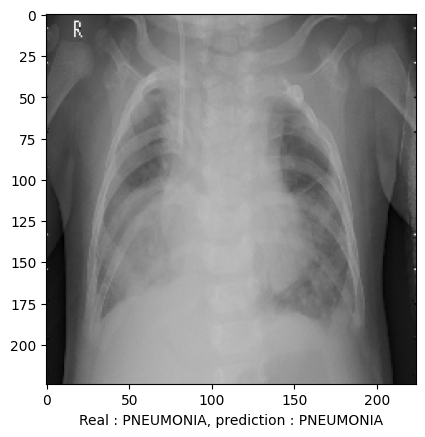

In [22]:
#Sample prediction 
smpl_index = 5

sample_image_from_valid = np.expand_dims(validation_images[smpl_index], axis = 0)
valid_example_prediction = model.predict(sample_image_from_valid).ravel()

binary_prediction = 1 if valid_example_prediction >= thres else 0

plt.imshow(validation_images[smpl_index], cmap = plt.cm.binary)
plt.xlabel(f"Real : {reversed_dict[validation_labels[smpl_index]]}, prediction : {reversed_dict[binary_prediction]}")
plt.show()

From the code below we can see how many times our machine learning model predicted the class of the image incorrectly

In [23]:
#Sample predictions for erroneus results
error_index_pred = {}
for i in range(0, len(validation_images)) :
    smpl_img_index = i

    sample_image_from_valid = np.expand_dims(validation_images[smpl_img_index], axis = 0)
    valid_example_prediction = model.predict(sample_image_from_valid).ravel()

    binary_prediction = 1 if valid_example_prediction >= thres else 0

    if reversed_dict[validation_labels[smpl_img_index]] != reversed_dict[binary_prediction] :
        error_index_pred[smpl_img_index] = binary_prediction
print(len(error_index_pred))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Samples from incorrect predictions

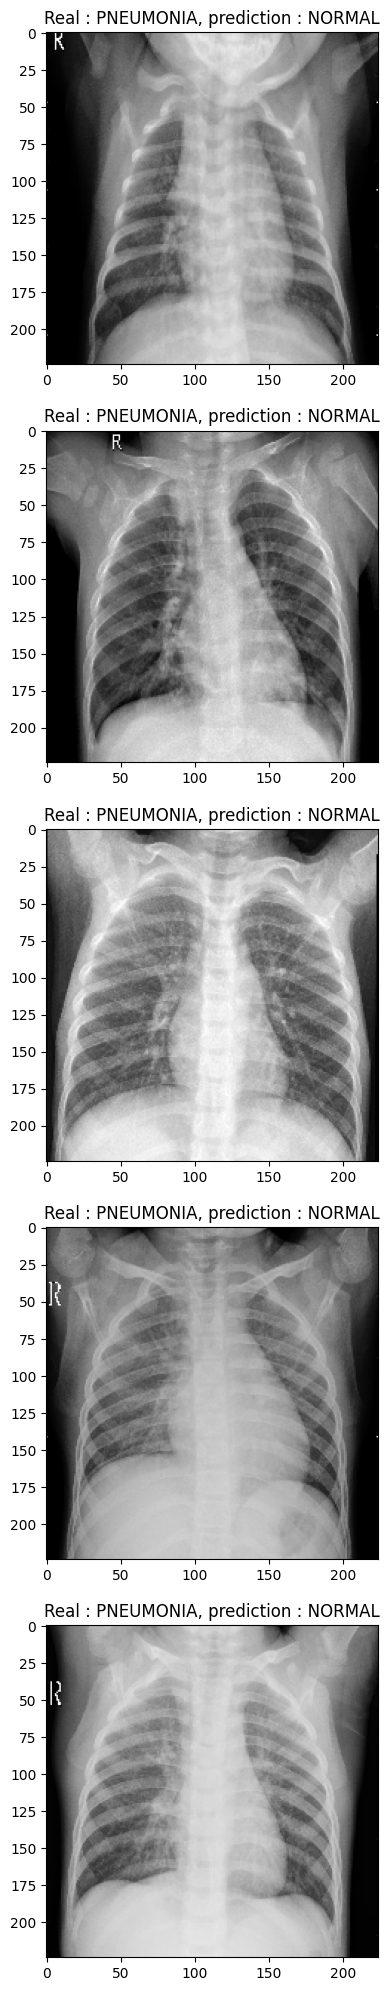

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(5, 25))

keys_list = list(error_index_pred.keys())[:5]
values_list = list(error_index_pred.values())[:5]

for index_img, pred_index_img  in zip(range(0, 5), keys_list) :
    axes[index_img].imshow(validation_images[pred_index_img], cmap = plt.cm.binary)
    axes[index_img].set_title(f"Real : {reversed_dict[validation_labels[pred_index_img]]}, prediction : {reversed_dict[values_list[index_img]]}")

plt.show()

All in all, both neural networks performed astonishingly good in terms of detection of the disorder from the images. But I am going to try other models as well if we would get more ideal score. The next model which I am going to test is the models from fastai library. I will use other models as well for this task.

So far I have done amazing things out of customer and pretrained neural networks. I think it is time to create machine learning model which can actually generate the image according to the class provided. That would potentially improve our understanding of the disorder pneumonia.

For that purpose I am going to use **GAN(Generative adversial networks)** which always work with two different neural networks(generator and discriminator). As name suggest generator neural networks generate the random images and get the feedback on the quality of the image from discriminator image. As time passes, it will learn how to draw the image of pneumonia disorder and may help us to what are the features it considered as the significant factor for pneumonia disorder.

### **GEN(Generative adversial networks)**

In [37]:
#Generator model
def build_generator() :
    input_layer = Input(shape=(100,))
    x = Dense(256 * 28 * 28)(input_layer)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Reshape((28, 28, 256))(x)
    
    # Upsample to 56x56
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Upsample to 112x112
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Upsample to 224x224
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    output_layer = Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

Some additional information about leaky relu and it's difference from conventional relu actication function.

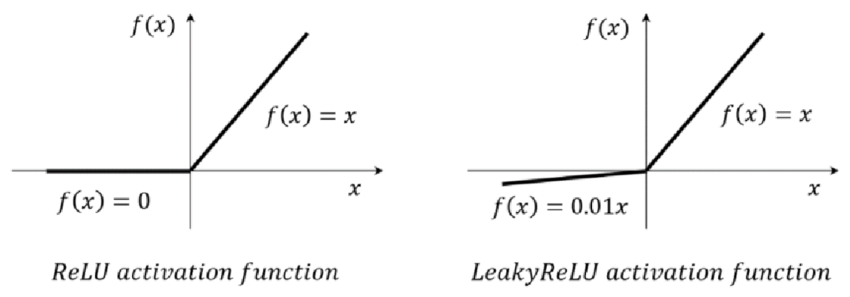

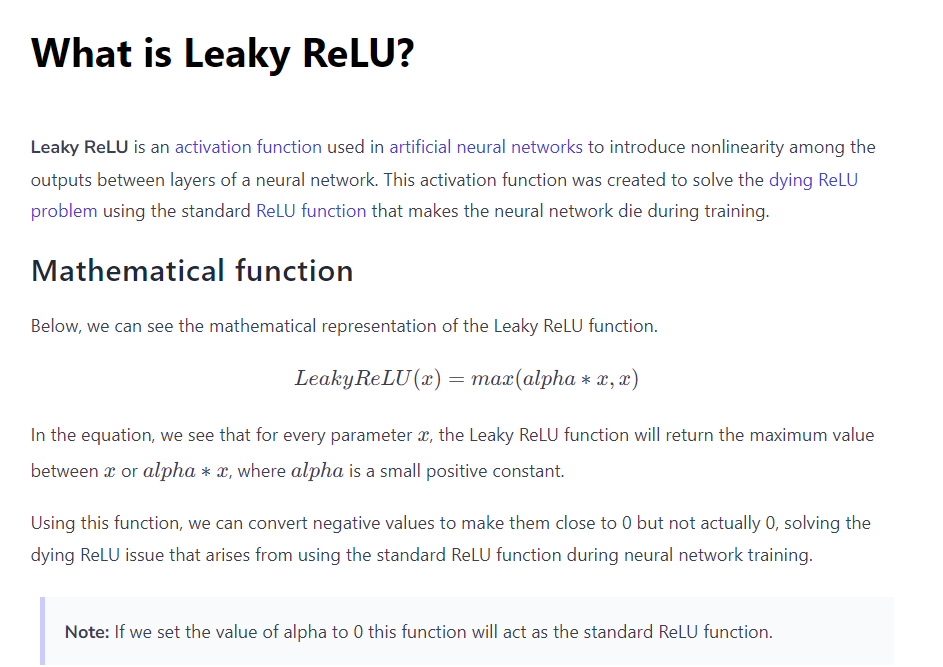

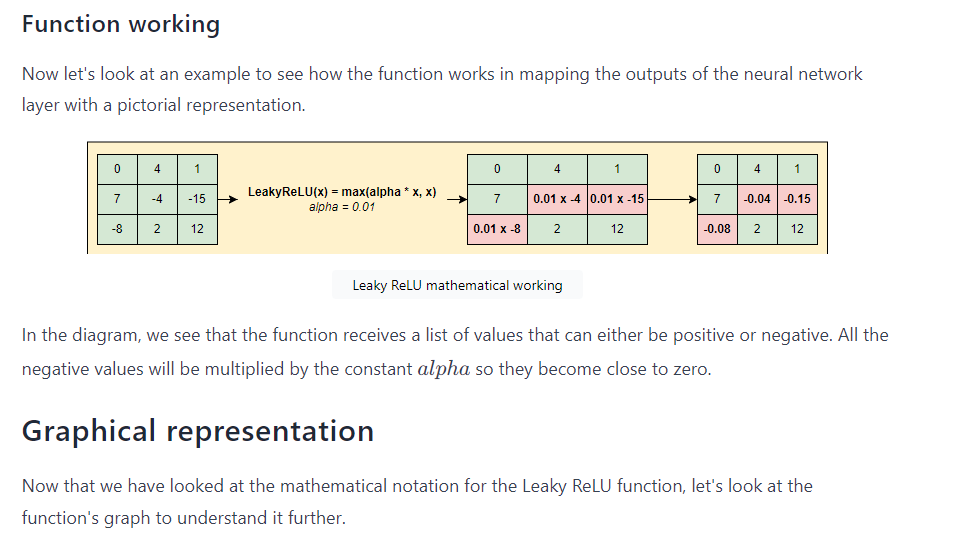

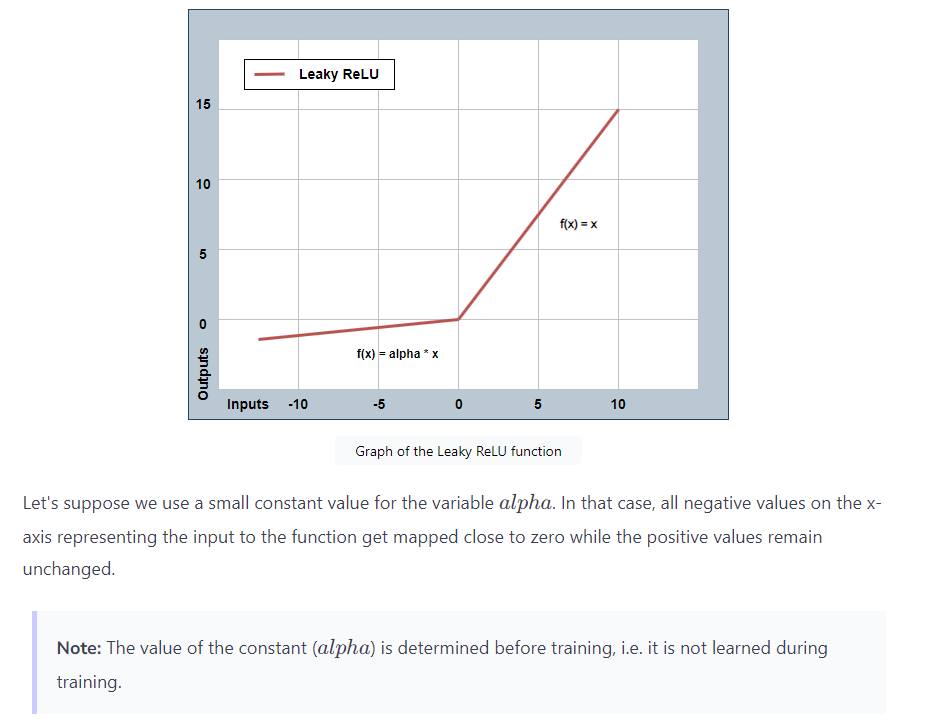

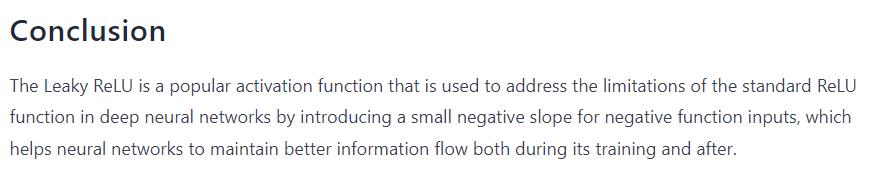

In [38]:
#Discriminator neural network for generative adversial neural networks
def build_discriminator() :
    vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    for layer in vgg19.layers :
        layer.trainable = False

    x = Flatten()(vgg19.output)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=vgg19.input, outputs=output_layer)
    return model

Next steps here is compiling and training GAN neural networks.

In [39]:
#Building and compiling discriminator
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy', tf.keras.metrics.AUC(name = 'roc_auc')])

#Building generator 
generator = build_generator()

#GAN model with input and output data
gan_input = Input(shape = (100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = Model(gan_input, gan_output)
gan.compile(loss =  'binary_crossentropy', optimizer = Adam(0.0002, 0.5))

Training GAN with my dataset

In [41]:
#General adversial networks
def train_gan(generator, discriminator, gan, train_generator, epochs = 10000, batch_size = 64) : 
    half_batch = batch_size // 2 

    for epoch in range(epochs) : 
        real_images, real_labels = next(train_generator)
        real_images =  real_images[ : half_batch]
        real_labels = real_labels[ : half_batch]

        real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)

        #Training discriminator with fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        fake_images = tf.convert_to_tensor(fake_images, dtype=tf.float32)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        #Training GAN
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))

        noise = tf.convert_to_tensor(noise, dtype=tf.float32)
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 1000 == 0 : 
            print(f"Epoch {epoch} | D Loss: {0.5 * np.add(d_loss_real, d_loss_fake)} | G Loss: {g_loss}")

#Training GAN
train_gan(generator = generator, discriminator = discriminator, gan = gan, train_generator = train_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Epoch 0 | D Loss: [0.5831836 0.7295573 0.8592421] | G Loss: [array(0.5778202, dtype=float32), array(0.5778202, dtype=float32), array(0.73828125, dtype=float32), array(0.8614421, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 